In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from wordcloud import WordCloud
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("C:/Users/DELL/Downloads/archive (9)/IMDB Dataset.csv")

In [3]:
df.head()


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
df.shape


(50000, 2)

In [5]:
df['review'][0]


"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

In [6]:
#Sentiment count
df['sentiment'].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

In [7]:
# Étiquettes binaires : 1 = positif, 0 = négatif
df['label'] = df['sentiment'].map({'positive': 1, 'negative': 0})

In [8]:
df.head()
df['review'].iloc[0]


"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

In [9]:
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
def clean_text(text):
    text = text.lower()
    text = re.sub(r"<.*?>", "", text)  
    text = re.sub(r"[^\w\s]", "", text)  
    text = " ".join([word for word in text.split() if word not in stop_words])  
    return text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
df['clean_review'] = df['review'].apply(clean_text)


In [11]:
X = df['clean_review']
y = df['label']

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split


vectorizer = CountVectorizer(max_features=5000)
X_bow = vectorizer.fit_transform(df['clean_review']).toarray()
y = df['label'].values.reshape(1, -1)


X_train, X_test, y_train, y_test = train_test_split(X_bow, y.T, test_size=0.2, random_state=42)
X_train = X_train.T
X_test = X_test.T
y_train = y_train.T
y_test = y_test.T

In [12]:
# --------------------------
# FONCTIONS DU MLP
# --------------------------
from sklearn.metrics import accuracy_score, log_loss
from tqdm import tqdm
def initialisation(dimensions):
    parametres = {}
    C = len(dimensions)
    np.random.seed(1)
    for c in range(1, C):
        parametres['W' + str(c)] = np.random.randn(dimensions[c], dimensions[c - 1])
        parametres['b' + str(c)] = np.random.randn(dimensions[c], 1)
    return parametres

def forward_propagation(X, parametres):
    activations = {'A0': X}
    C = len(parametres) // 2
    for c in range(1, C + 1):
        Z = parametres['W' + str(c)].dot(activations['A' + str(c - 1)]) + parametres['b' + str(c)]
        activations['A' + str(c)] = 1 / (1 + np.exp(-Z))
    return activations

def back_propagation(y, parametres, activations):
    m = y.shape[1]
    C = len(parametres) // 2
    dZ = activations['A' + str(C)] - y
    gradients = {}
    for c in reversed(range(1, C + 1)):
        gradients['dW' + str(c)] = 1/m * np.dot(dZ, activations['A' + str(c - 1)].T)
        gradients['db' + str(c)] = 1/m * np.sum(dZ, axis=1, keepdims=True)
        if c > 1:
            dZ = np.dot(parametres['W' + str(c)].T, dZ) * activations['A' + str(c - 1)] * (1 - activations['A' + str(c - 1)])
    return gradients

def update(gradients, parametres, learning_rate):
    C = len(parametres) // 2
    for c in range(1, C + 1):
        parametres['W' + str(c)] -= learning_rate * gradients['dW' + str(c)]
        parametres['b' + str(c)] -= learning_rate * gradients['db' + str(c)]
    return parametres

def predict(X, parametres):
    activations = forward_propagation(X, parametres)
    C = len(parametres) // 2
    Af = activations['A' + str(C)]
    return Af >= 0.5

def deep_neural_network(X, y, couche_cachees=(32, 16), learning_rate=0.1, n_iter=1000):
    dimensions = list(couche_cachees)
    dimensions.insert(0, X.shape[0])
    dimensions.append(y.shape[0])
    parametres = initialisation(dimensions)
    training_history = np.zeros((int(n_iter), 2))
    C = len(parametres) // 2
    for i in tqdm(range(n_iter)):
        activations = forward_propagation(X, parametres)
        gradients = back_propagation(y, parametres, activations)
        parametres = update(gradients, parametres, learning_rate)
        Af = activations['A' + str(C)]
        training_history[i, 0] = log_loss(y.flatten(), Af.flatten())
        y_pred = predict(X, parametres)
        training_history[i, 1] = accuracy_score(y.flatten(), y_pred.flatten())
    return parametres, training_history

In [13]:
parametres, history = deep_neural_network(X_train, y_train, couche_cachees=(512,256,128,64), learning_rate=0.1, n_iter=700)


100%|██████████████████████████████████████████████████████████████████████████████| 700/700 [4:22:56<00:00, 22.54s/it]


In [14]:
y_pred_test = predict(X_test, parametres)
print("Accuracy test :", accuracy_score(y_test.flatten(), y_pred_test.flatten()))

Accuracy test : 0.5599


In [15]:
# --------------------------
# SAUVEGARDE DU MODÈLE ET DU VECTEUR
# --------------------------
import pickle
with open("mlp_sentiment.pkl", "wb") as f:
    pickle.dump(parametres, f)

with open("vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)

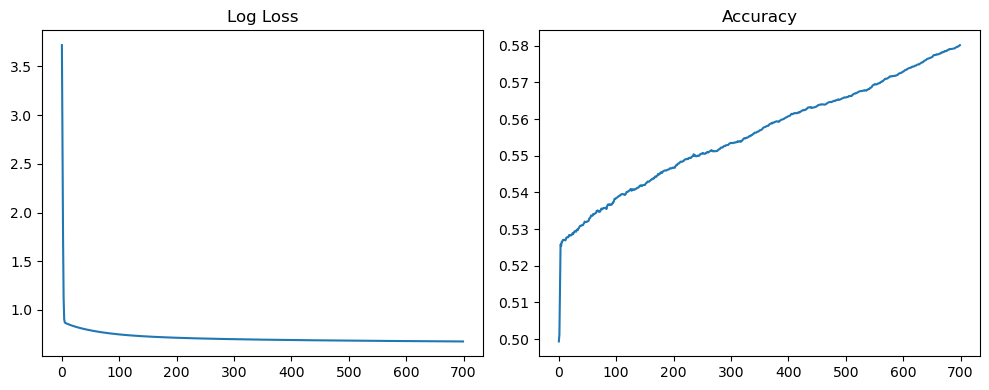

In [16]:
# --------------------------
# COURBES D'APPRENTISSAGE
# --------------------------
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history[:,0])
plt.title("Log Loss")
plt.subplot(1,2,2)
plt.plot(history[:,1])
plt.title("Accuracy")
plt.tight_layout()
plt.show()